In [1]:
# Import basic libraries
from palmerpenguins import load_penguins
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
import time
from sklearn.preprocessing import LabelEncoder
import os
os.chdir("/Users/hoangthuyduongvu/Desktop/FuzzSIM")


In [5]:
# Import personalized libraries
from fuzz.src.capacity import *
from fuzz.choquet.choquet import *
from fuzz.src.norm import *
from fuzz.src.knn import KNNFuzz
from fuzz.src.sim import S1, S2, S3
from fuzz.optim import *
from fuzz.utils import *
from fuzz.eval import leave_one_out
from fuzz.dataloader import *
from fuzz.choquet.d_choquet import *

In [6]:
# Load data 
iris_data = load_iris()
iris = pd.DataFrame(data=iris_data.data, columns=iris_data.feature_names)
iris['target'] = iris_data.target
data, labels = iris.iloc[:, :-1].values, iris.iloc[:, -1].values
data = batch_norm(np.array(data, dtype=np.float32))

# data, labels = dynamic_generate_positive_gaussian_data(
#     dim=3,
#     nb_classes=3,
#     nb_points_per_class=100,
#     seed=42
# )
# data = batch_norm(data)
data[:5]

array([[1.        , 0.67346936, 0.24489795, 0.        ],
       [1.        , 0.59574461, 0.25531912, 0.        ],
       [1.        , 0.66666669, 0.24444443, 0.        ],
       [1.        , 0.65909088, 0.29545453, 0.        ],
       [1.        , 0.70833325, 0.24999997, 0.        ]])

In [31]:
# Generate all possible mobius for training
features = list(range(len(data[0])))    # encode features as integers

nb_total = 5

# Input Mobius (10 mobius currently)
lst_mobius = []
for i in range(nb_total):
    mobius = generate_mobius(features, 2)
    mobius.pop(0)
    lst_mobius.append(mobius)

# Mutate all mobius
mutated = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    mutated_mobius = mutate(mobius, mutation_rate=0.8)
    mutated.append(mutated_mobius)

# Add mutated mobius to the list
lst_mobius.extend(mutated)

# Cross over all mobius
crossed_over = []
for i in range(len(lst_mobius)):
    for j in range(i + 1, len(lst_mobius) // 2):
        crossed = crossover(lst_mobius[i], lst_mobius[j])
        crossed_over.append(crossed)

# Add crossed over mobius to the list
lst_mobius.extend(crossed_over)
print(f"Total number of Möbius measures: {len(lst_mobius)}")

# Convert all Möbius measures to capacities
capacities_list = []
for i in range(len(lst_mobius)):
    mobius = lst_mobius[i]
    capacity = mobius_to_capacity(mobius, features)
    capacities_list.append(capacity)    
print('Test Möbius measures completed!')
print(f"Total number of capacities: {len(capacities_list)}")

Total number of Möbius measures: 20
Test Möbius measures completed!
Total number of capacities: 20


In [ ]:
# Define hyperparameters
p = range(1, 3)
q = range(1, 3)
sim = [S1, S2, S3]  # similarity measures
choquet_version = 'linear'
verbose = False 

# Define training loop
best_indexes = []
best_accuracies = []
best_mobius = []

print("Starting training loop...")
start_time = time.time()
i = 0
for p_val in p:
    for q_val in q:
        for sim_measure in sim:
            i += 1
            if i % 10 == 0:
                elapsed_time = time.time() - start_time
                print(f"Iteration {i}/{len(p) * len(q) * len(sim)} completed in {elapsed_time:.2f} seconds")
            FF_res = fitness_function(
                capacities_list=lst_mobius,
                DS=(data, labels),
                sim=sim_measure,
                choquet_version=choquet_version,
                p=p_val,
                q=q_val,
                time_counter=False,
                verbose=verbose
            )
            best_indexes.append(np.argmin(FF_res))
            best_accuracies.append(-FF_res[np.argmin(FF_res)])
            best_mobius.append(lst_mobius[np.argmin(FF_res)])

Starting training loop...


In [ ]:
# Find the best index and accuracy
best_index = np.argmax(best_accuracies)
best_accuracy = best_accuracies[best_index]
print(f"Best index: {best_index}, Best accuracy: {best_accuracy}")

# get best mobius
mobius = best_mobius[best_index]
print(f"Best Möbius measure: {[f'{m.X}: {m.mu:.3f}' for m in mobius]}")

# Convert mobius to capacity
best_capacity = mobius_to_capacity(mobius, features)
print("\nBest Capacity:")
for c in best_capacity:
    print(f"Capacity of {c.X} is {c.mu:.3f}")

# Evaluate the best capacity
best_accuracy = FuzzLOO(
    DS=(data, labels),
    mu=best_capacity,
    sim=S1,
    choquet_version='linear',
    p=1,
    q=1,
    time_counter=True
)
print(f"Best accuracy: {best_accuracy:.4f}")

Best index: 5, Best accuracy: 0.9266666666666666
Best Möbius measure: ['[0]: 0.438', '[1]: 0.445', '[2]: 0.244', '[3]: 0.591', '[0, 1]: 0.967', '[0, 2]: 0.775', '[0, 3]: 0.470', '[1, 2]: 0.942', '[1, 3]: 0.216', '[2, 3]: 0.002']

Best Capacity:
Capacity of [] is 0.000
Capacity of [0] is 0.086
Capacity of [1] is 0.087
Capacity of [2] is 0.048
Capacity of [3] is 0.116
Capacity of [0, 1] is 0.363
Capacity of [0, 2] is 0.286
Capacity of [0, 3] is 0.295
Capacity of [1, 2] is 0.320
Capacity of [1, 3] is 0.246
Capacity of [2, 3] is 0.165
Capacity of [0, 1, 2] is 0.749
Capacity of [0, 1, 3] is 0.614
Capacity of [0, 2, 3] is 0.495
Capacity of [1, 2, 3] is 0.479
Capacity of [0, 1, 2, 3] is 1.000
Result in 2.8797 seconds.
Best accuracy: 0.6600


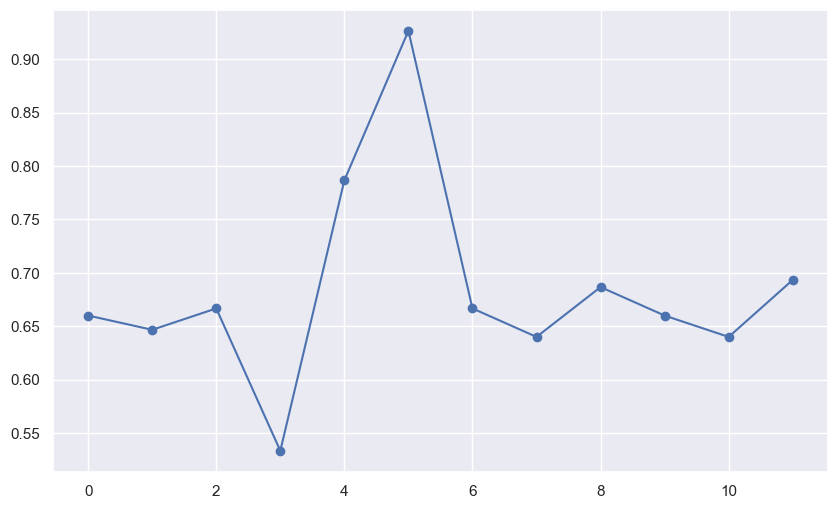

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(best_accuracies, marker='o', linestyle='-', color='b')